In [170]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *

In [171]:
true_trajectory, noisy_observations = generate_trajectory_nonlinear()

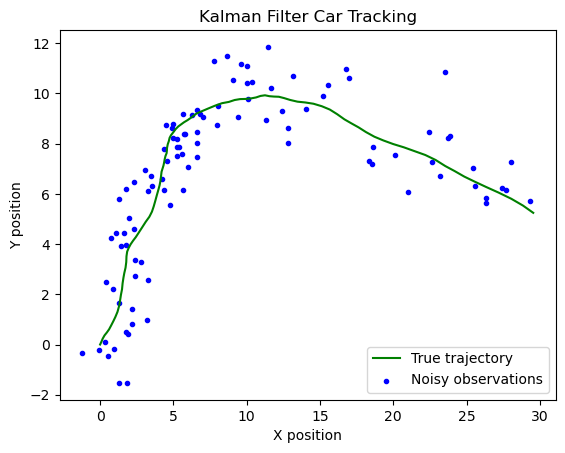

In [172]:
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.title('Kalman Filter Car Tracking')
plt.show()

In [287]:
from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
from tqdm import tqdm


def create_uniform_particles(x_range, y_range, dx_range, dy_range, N):
    particles = np.empty((N, 4))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(dx_range[0], dx_range[1], size=N)
    particles[:, 3] = uniform(dy_range[0], dy_range[1], size=N)
    return particles

# Draw N samples from the prior
N = 1000
particles = create_uniform_particles((-5,5), (-5,5), (-5, 5), (-5, 5), N)
weights = np.ones(N) / N

P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_particle = [m]
P_particle = [P]
particles_hist = [particles]
weights_hist = [weights]

# SIR particle smoothe
for y in tqdm(noisy_observations[1:]):
    particles = np.array([f(particle) + mvn([0, 0, 0, 0], Q) for particle in particles])
    
    # Update weights
    for i, particle in enumerate(particles):
        weights[i] *= scipy.stats.multivariate_normal(h(particle), R).pdf(y)
    weights += 1.e-300 # avoid round-off to zero
    weights /= sum(weights)
    
    if 1. / np.sum(np.square(weights)) < N / 2:
        # Systematic resampling
        positions = (np.arange(N) + np.random.random()) / N
        indexes = np.zeros(N, 'i')
        cumulative_sum = np.cumsum(weights)
        i, j = 0, 0
        while i < N:
            if positions[i] < cumulative_sum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1
        
        # Resample from index
        particles[:] = particles[indexes]
        weights.resize(len(particles))
        weights.fill(1.0 / len(weights))

    m = np.average(particles, weights=weights, axis=0)
    # Calculate covariance matrix of particles
    P = np.zeros((4, 4))
    for particle, weight in zip(particles, weights):
        diff = (particle - m)[np.newaxis]
        P += weight * np.dot(diff.T, diff)
    
    estimated_trajectory_particle.append(m)
    P_particle.append(P)
    particles_hist.append(particles)
    weights_hist.append(weights)
    
estimated_trajectory_particle = np.array(estimated_trajectory_particle)
P_particle = np.array(P_particle)
particles_hist = np.array(particles_hist)

100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


In [288]:
from matplotlib.patches import Ellipse
from scipy.linalg import eigh
from scipy.stats import chi2

cornflowerblue_alpha = (0.39215686274509803, 0.5843137254901961, 0.9294117647058824, 0.3)

def rgba_to_rgb(rgba, bg=(1, 1, 1)):
    r, g, b, a = rgba
    bg_r, bg_g, bg_b = bg
    
    # Blend the RGBA color with the background color
    r = r * a + bg_r * (1 - a)
    g = g * a + bg_g * (1 - a)
    b = b * a + bg_b * (1 - a)

    return (r, g, b)

def conf_ellipse(ax, center, covariance, alpha=0.95):
    chi2_quantile = chi2.ppf(alpha, 2)
    eigvals, eigvecs = eigh(covariance)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals[0] * chi2_quantile), 2 * np.sqrt(eigvals[1] * chi2_quantile)
    ell = Ellipse(xy=center, width=width, height=height, angle=angle, fill=True, facecolor=rgba_to_rgb(cornflowerblue_alpha))
    ax.add_artist(ell)

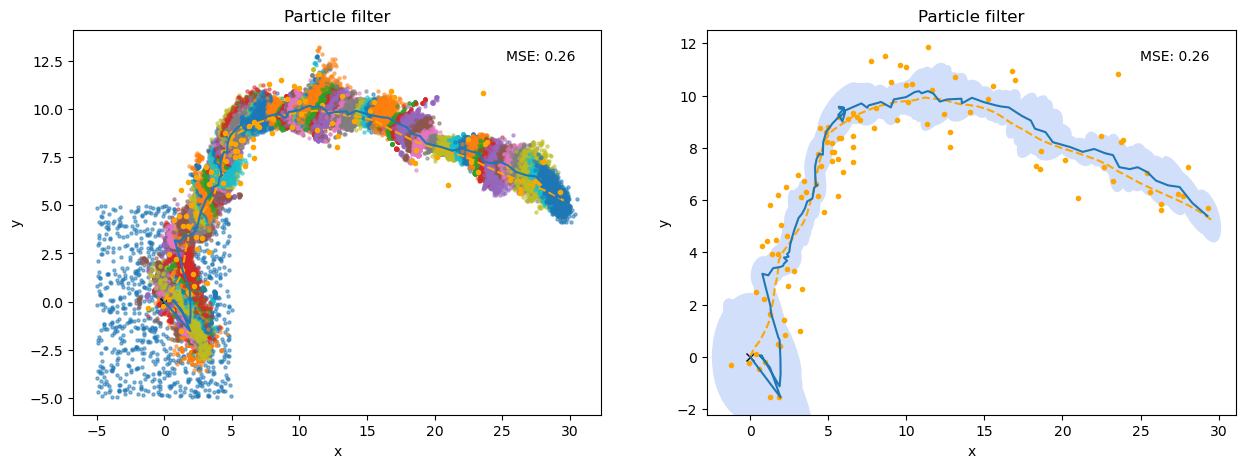

In [289]:
#Compare methods
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for k in range(2):
    ax[k].plot(true_trajectory[0, 0], true_trajectory[0, 1], 'x', color='k', label="Start")
    ax[k].plot(true_trajectory[:, 0], true_trajectory[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', color='orange', label="Noisy observations")
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")
    
ax[0].plot(estimated_trajectory_particle[:, 0], estimated_trajectory_particle[:, 1])  
ax[0].set_title("Particle filter")

ax[1].plot(estimated_trajectory_particle[:, 0], estimated_trajectory_particle[:, 1])
ax[1].set_title("Particle filter")

# Compute MSE
UP1_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_particle[:, :2])**2)
UP2_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_particle[:, :2])**2)

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(UP1_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(UP2_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

# # 95% confidence ellipses for the KF
for i in range(0, len(estimated_trajectory_particle)):
    #conf_ellipse(ax[0], estimated_trajectory_particle[i, :2], P_particle[i, :2, :2])
    ax[0].scatter(*particles_hist[i, :, :2].T, s=5, alpha=0.5)

# # 95% confidence ellipses for the EKF
for i in range(0, len(estimated_trajectory_particle)):
    conf_ellipse(ax[1], estimated_trajectory_particle[i, :2], P_particle[i, :2, :2])
    
plt.show()